# 1. Import Libraries

In [1]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import scipy
import textwrap

# 2. Etherscan API Call

In [2]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    with open("transactionsResponse.json", "w") as write_file:
        json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON

In [3]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [4]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b'
]

In [5]:
rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# of Transactions: 2748
# of Transactions: 739
# of Transactions: 506
# of Transactions: 3


In [6]:
# print(rawTransactionData)

In [7]:
def getStartAndEndDate(transactionData):

    startDate = 99999999999
    endDate = 0

    for transaction in transactionData:
        timeStamp = int(transaction.get('timeStamp'))

        if timeStamp < startDate:
            startDate = timeStamp
        elif timeStamp > endDate:
            endDate = timeStamp

    return startDate, endDate

In [8]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # returns type str

In [9]:
startDate, endDate = getStartAndEndDate(rawTransactionData)
print(startDate, endDate)
startDate = str(convert_UNIX_to_DateTime(startDate))[0:10]
endDate = str(convert_UNIX_to_DateTime(endDate))[0:10]
print(startDate, endDate)

1565194663 1670685071
2019-08-07 2022-12-10


In [10]:
def getDailyTransactionVolumeForListOfWallets(transactionData):
    dailyTransactionVolume = {}

    for transaction in transactionData:
        timeStamp = convert_UNIX_to_DateTime(transaction.get("timeStamp"))
        timeStamp = timeStamp[0:10]
        if (timeStamp in dailyTransactionVolume):
            cnt = dailyTransactionVolume.get(timeStamp) + 1
            dailyTransactionVolume[timeStamp] = cnt
        else:
            dailyTransactionVolume[timeStamp] = 1


    ordered_data = sorted(dailyTransactionVolume.items(), key = lambda x:datetime.strptime(x[0],'%Y-%m-%d'), reverse=False)

    # print(type(ordered_data))
    # print(type(dict(ordered_data)))
    # print(dict(ordered_data))

    return dict(ordered_data)

In [11]:
dailyTransactionVolume = getDailyTransactionVolumeForListOfWallets(rawTransactionData)

In [12]:
# print(dailyTransactionVolume)

In [13]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    data.to_csv('tokenPriceData.csv')
    return data

In [14]:
rawTokenData = getCryptoHistoricalData('MATIC-USD', startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00
Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [15]:
def getRangePrices(tokenData):
    highPrices = list(tokenData["high"])
    lowPrices = list(tokenData["low"])
    rangePrices = [a - b for a, b in zip(highPrices, lowPrices)]
     
    dateTimes = tokenData.index.tolist()

    datesToRangePrice = {}
    cnt = 0

    for dateTime in dateTimes:
        datesToRangePrice[str(dateTime)[0:10]] = rangePrices[cnt]
        cnt += 1

    # print(datesToRangePrice)
    return datesToRangePrice

In [16]:
dailyTokenPriceAction = getRangePrices(rawTokenData)

In [17]:
def alignTransactionsToPrice(transactions, prices):

    newTransactions = {}

    for key in prices.keys():
        if (key in transactions):
            newTransactions[key] = transactions.get(key)
        else:
            newTransactions[key] = 0

    # print(len(prices))
    # print(len(transactions))
    # print(len(newTransactions))
    # print(newTransactions)

    return newTransactions

In [18]:
dailyTransactionVolume = alignTransactionsToPrice(dailyTransactionVolume, dailyTokenPriceAction)

In [19]:
def createPlotFromDict(dict, title, x, y, description):
    keys = dict.keys()
    values = dict.values()

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    # plt.figtext(0.5, -30, description, wrap=True, horizontalalignment='center', fontsize=10)

    # plt.bar(keys, values)
    plt.plot(keys, values)

    # add a description to the graph
    # text = textwrap.wrap(description, width=40)
    # plt.text(0, 20,'\n'.join(text), fontsize=10, ha='left', va='bottom')
    plt.figtext(0.5, -0.1, description, wrap=True, horizontalalignment='center', fontsize=12)

    # plots bar chart of keys (x) against values (y)
    plt.savefig(title+".png", dpi=300, bbox_inches = "tight")

In [20]:
def printDataSet(data):
    print("Data Length:", len(data))
    print(str(data)+"\n")

In [27]:
# printDataSet(dailyTransactionVolume)
# printDataSet(dailyTokenPriceAction)

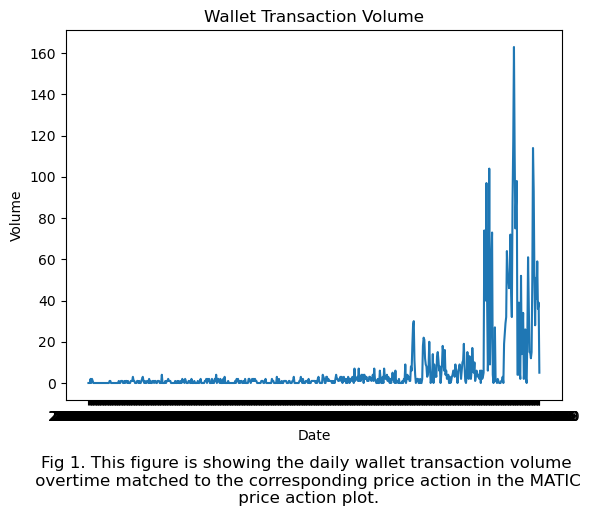

In [28]:
createPlotFromDict(dailyTransactionVolume, "Wallet Transaction Volume", "Date", "Volume", "Fig 1. This figure is showing the daily wallet transaction volume\n overtime matched to the corresponding price action in the MATIC\n price action plot.")

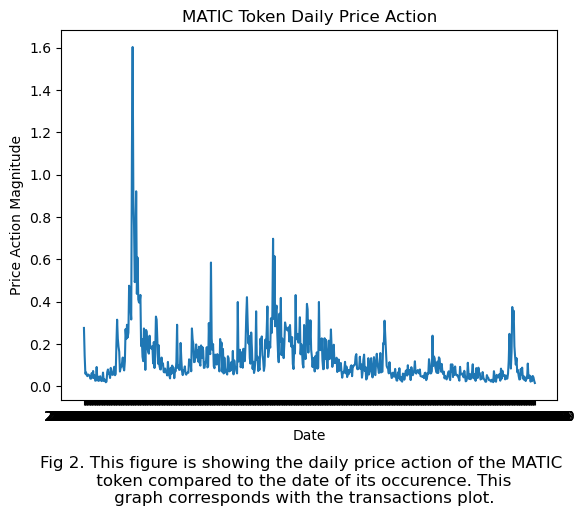

In [29]:
createPlotFromDict(dailyTokenPriceAction, "MATIC Token Daily Price Action", "Date", "Price Action Magnitude", "Fig 2. This figure is showing the daily price action of the MATIC\n token compared to the date of its occurence. This\n graph corresponds with the transactions plot.")

In [30]:
def performLinearRegression(data1, data2):
    a = list(data1.values())
    b = list(data2.values())

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

In [31]:
performLinearRegression(dailyTransactionVolume, dailyTokenPriceAction)

R_value: 0.012432546490100251
P_value: 0.004741627729203001


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

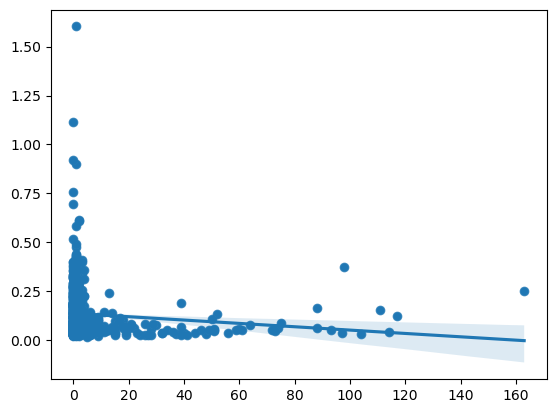

In [33]:
import seaborn as sns

transactionVolume = list(dailyTransactionVolume.values())
tokenPriceAction = list(dailyTokenPriceAction.values())

# Create the scatter plot
sns.scatterplot(transactionVolume, tokenPriceAction)

# Add the linear regression line
sns.regplot(transactionVolume, tokenPriceAction)
